In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from transformers import AdamW
import pandas as pd
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import csv
import re
import validators
import emoji
import unidecode
import nltk
import pickle
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Mark Gabriel
[nltk_data]     Ortiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set the seed for reproducibility
SEED = 1235
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# BERT Hyperparameters (ADDITION)
n_bert_layers = 16  # Assuming the base model has 12 layers
bert_lr = 0.001
pooling_strategy = 'cls'  # Options: 'cls', 'mean', 'max'
bert_hidden_size = 1024  # Adjust based on your BERT model
max_seq_length = 128
fine_tune_strategy = 'last_layer'  # Options: 'full', 'last_layer'
bert_dropout = 0.9  # Adjust based on BERT model specifications

max_seq_length = 128  # This should match the max_seq_length used in BERT model
padding_strategy = 'max_length'  # Options: 'max_length', 'do_not_pad', 'longest'
truncation_strategy = 'longest_first'  # Options: 'longest_first', 'only_first', 'only_second'
do_lower_case = False  # Set to False if using a cased model

config = BertConfig(
    num_hidden_layers=n_bert_layers,
    hidden_size=bert_hidden_size,
    num_attention_heads=16,  # Assuming 12 attention heads
    intermediate_size=4 * bert_hidden_size,  # Default value in BERT
    hidden_dropout_prob=bert_dropout,
    attention_probs_dropout_prob=bert_dropout,
)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', 
                                          max_length=max_seq_length,
                                          padding=padding_strategy,
                                          truncation=truncation_strategy,
                                          do_lower_case=do_lower_case)
# Load the BERT model with the custom configuration
bert_model = BertModel(config=config)


In [3]:
data_path = 'dataset.csv'
data_df = pd.read_csv(data_path)
data_df = data_df.rename(columns={'Tweet Content': 'text', 'Label': 'label'})

In [4]:
data_df.head()

,text,Sentiment,label
0,KULANG ATA SA TULOG SI NORBERTO GONZALES HAHAH...,Negative,Hate
1,Hirosii's argument screams misogyny not valid ...,Negative,Hate
2,"Who is the better vote? Bongbong #marcos, who ...",Negative,Hate
3,@skzoowifey hindi siya ang tatay niya bc from ...,Negative,Hate
4,"@Pontifex @LaityFamilyLife Bongbong Marcos,Sar...",Negative,Hate


In [5]:
groupedby_sentiment = data_df.groupby(data_df.Sentiment)
data_df_positive = groupedby_sentiment.get_group("Positive")
data_df_positive

,text,Sentiment,label
2400,"It's just so fitting for Leni Robredo, as an h...",Positive,Non-hate
2401,The Solution.\n\n* Leni Robredo - Philippines ...,Positive,Non-hate
2402,@kikopangilinan @donny @bellemariano02 So prou...,Positive,Non-hate
2403,"Ako si Bernard isang guro,nakiki-isa sa pagsup...",Positive,Non-hate
2404,"@DonKissPlatum Para sa Bayan, Para sa Pagbabag...",Positive,Non-hate
...,...,...,...
3595,@GelSantosRelos @lenirobredo @cnnphilippines i...,Positive,Non-hate
3596,Wala akong duda na sa ating sama-samang pagkil...,Positive,Non-hate
3597,The most qualified president\nPing Lacson lang...,Positive,Non-hate
3598,"""Sa Gobyernong Tapat, Angat Buhay Lahat! At si...",Positive,Non-hate


In [6]:
data_df_negative = groupedby_sentiment.get_group("Negative")
data_df_negative

,text,Sentiment,label
0,KULANG ATA SA TULOG SI NORBERTO GONZALES HAHAH...,Negative,Hate
1,Hirosii's argument screams misogyny not valid ...,Negative,Hate
2,"Who is the better vote? Bongbong #marcos, who ...",Negative,Hate
3,@skzoowifey hindi siya ang tatay niya bc from ...,Negative,Hate
4,"@Pontifex @LaityFamilyLife Bongbong Marcos,Sar...",Negative,Hate
...,...,...,...
2395,Absent for today’s videyow:\n1. Bongbong Marco...,Negative,Hate
2396,@DisguisedPost @_Nathalieperona Mawalang galan...,Negative,Hate
2397,"Get ready for 'BongBong' Marcos!\n\nHa, what a...",Negative,Hate
2398,Sabi ng iba bobo daw si Leni. Bobo pa siya sa ...,Negative,Hate


In [7]:
data_df_neutral = groupedby_sentiment.get_group("Neutral")
data_df_neutral

,text,Sentiment,label
3600,"In front of a huge crowd, Cebu Governor Gwen G...",Neutral,Non-hate
3601,ANSABE NG 6 MILLION VIEWS SA KATATAPOS LANG NA...,Neutral,Non-hate
3602,Mga di nagdidiet for Leni Robredo CHAROTTT,Neutral,Non-hate
3603,Madam President ackkkk keleg iz meh\nPresident...,Neutral,Non-hate
3604,👀 Bongbong yo-yo 🇵🇭 \n\n#Marcos 💸 https://t.co...,Neutral,Non-hate
...,...,...,...
4795,President Leni Robredo supporters 💚✅☘️🌲🌴🥑🌿📚🥦🥒🍏...,Neutral,Non-hate
4796,"gonna start muting vp leni pics for now, my dr...",Neutral,Non-hate
4797,"Sa Gobyernong Tapat, Angat Buhay Lahat! Ang Pr...",Neutral,Non-hate
4798,Ang presidente... Leni Robredo\nBise President...,Neutral,Non-hate


In [8]:
#binary hate non-hate
data_df_hate = data_df_negative.sample(n = 2560, replace=True)

data_df_positive = data_df_positive.sample(n = 1280, replace=True)
data_df_neutral = data_df_neutral.sample(n = 1280, replace=True)

data_df_nonhate = data_df_positive.append(data_df_neutral)

data_df = data_df_hate.append(data_df_nonhate)

C:\Users\Mark Gabriel Ortiz\AppData\Local\Temp\ipykernel_6108\2699631638.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_nonhate = data_df_positive.append(data_df_neutral)
C:\Users\Mark Gabriel Ortiz\AppData\Local\Temp\ipykernel_6108\2699631638.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df_hate.append(data_df_nonhate)


In [9]:
data_df = data_df.drop(['Sentiment'], axis = 1)

In [10]:
#data_df.to_csv('dataset.csv', index=False)
data_df

,text,label
1489,@sosyolohija MarcosJr. duwag. Ayaw umattend ng...,Hate
2178,Ayaw KO sa mga KABIT....\nKaya never ko magigi...,Hate
1902,"This debate just sealed the deal, I am all for...",Hate
34,"puro pagmamalaki sa nagawa daw ni marcos e, pa...",Hate
1380,HUH? BONGBONG MARCOS TALKING ABOUT DISTRIBUTIO...,Hate
...,...,...
4278,@HelloMy2ndAcct Di ba naguwi ng Covid yan dahi...,Non-hate
4273,@pointdevue__ @Emilian22847466 @nicoquejano Mo...,Non-hate
3944,Bongbong Marcos Song Part 2 ( OFFICIAL LYRIC V...,Non-hate
3643,Nag iisang Leni Robredo lang ang meron tayo 🌷🇵🇭,Non-hate


In [11]:
data_df = data_df.reset_index()

In [12]:
data_df

,index,text,label
0,1489,@sosyolohija MarcosJr. duwag. Ayaw umattend ng...,Hate
1,2178,Ayaw KO sa mga KABIT....\nKaya never ko magigi...,Hate
2,1902,"This debate just sealed the deal, I am all for...",Hate
3,34,"puro pagmamalaki sa nagawa daw ni marcos e, pa...",Hate
4,1380,HUH? BONGBONG MARCOS TALKING ABOUT DISTRIBUTIO...,Hate
...,...,...,...
5115,4278,@HelloMy2ndAcct Di ba naguwi ng Covid yan dahi...,Non-hate
5116,4273,@pointdevue__ @Emilian22847466 @nicoquejano Mo...,Non-hate
5117,3944,Bongbong Marcos Song Part 2 ( OFFICIAL LYRIC V...,Non-hate
5118,3643,Nag iisang Leni Robredo lang ang meron tayo 🌷🇵🇭,Non-hate


In [13]:
# data_df = "dataset.csv"

In [14]:
# Preprocessing function
def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = tokens[:tokenizer.model_max_length - 2]  # Account for [CLS] and [SEP] tokens
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
    return indexed_tokens

filipino_stopwords = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

# from nltk.corpus import stopwords
# english_stopwords = stopwords.words('english')

# search = "leni robredo bongbong marcos isko moreno domagoso manny pacman pacquiao ping lacson ernie abella leody de guzman norberto gonzales jose montemayor jr faisal mangondato"
# candidatelist = search.split(" ")

# Date De-Identification
def remove_mentions(text):
    mention_pattern = re.compile(r'@\w+')
    
    # Use re.sub to remove mentions
    cleaned_text = mention_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text

# URL Removal
def remove_url (text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Use re.sub to replace URLs with an empty string
    return url_pattern.sub('', text)

def remove_special_characters(text):
    text = emoji.replace_emoji(text, replace="[emoji]")
    
    # Split the text into words
    words = text.split(" ")
    
    # Initialize an empty string to store the cleaned text
    cleaned_text = ""
    
    # Iterate through each word
    for word in words:
        # Check if the word contains only special characters or "[emoji]"
        if not (re.match(r"^[_\W]+$", word) or "[emoji]" in word):
            if len(cleaned_text) == 0:
                cleaned_text = f"{word}"
            else:
                cleaned_text = f"{cleaned_text} {word}"
                
    # Remove diacritics
    text_no_diacritics = unidecode.unidecode(cleaned_text)

    # Split the text into words
    sentence = text_no_diacritics.split(" ")
    output = ""

    # Remove special characters and numerics
    for part in sentence:
        part = re.sub("[^A-Za-z ]+$", "", part)
        part = re.sub("^[^A-Za-z #]+", "", part)
        if not (len(part) <= 1 or re.match(r"[^a-zA-Z#]", part)):
            if len(output) == 0:
                output = f"{part}"
            else:
                output = f"{output} {part}"

    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(output.split())

    return cleaned_text

# Remove English Stop Words
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

def remove_english_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Remove Filipino Stop Words
def remove_filipino_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in filipino_stopwords]
    return ' '.join(filtered_words)

# Candidate Name Removal
def remove_candidate_names(text):
    candidatelist = "leni robredo bongbong marcos isko moreno domagoso manny pacman pacquiao ping lacson ernie abella leody de guzman norberto gonzales jose montemayor jr faisal mangondato"
    candidatelist = candidatelist.split()
    candidate_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, candidatelist)) + r')\b', re.IGNORECASE)
    
    # Use re.sub to remove candidate names
    cleaned_text = candidate_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())
        
    return cleaned_text

# Hashtag Removal
def remove_hashtags(text):
    # Split the text into words
    words = text.split()
    
    # Initialize an empty list to store cleaned words
    cleaned_words = []
    
    for word in words:
        # Check if the word is a hashtag (starts with #)
        if not word.startswith('#'):
            cleaned_words.append(word)
    
    # Join the cleaned words into a single string
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text

In [15]:
#PreProcessing

data_df['text'] = data_df['text'].apply(remove_mentions)

# URL Removal
data_df['text'] = data_df['text'].apply(remove_url)

 # Lowercase
# data_df['text'] = data_df['text'].str.lower()

# Remove Diacritics
data_df['text'] = data_df['text'].apply(remove_special_characters)

# Remove symbols and numerics using regex
#data_df['text'] = data_df['text'].str.replace(r'[^A-Za-z\s#]', '', regex=True)
# data_df['text'] = data_df['text'].str.replace(r'[^a-zA-Z0-9\s#!?]', '', regex=True)
data_df['text'] = data_df['text'].apply(remove_candidate_names)
data_df['text'] = data_df['text'].apply(remove_hashtags)

# Remove English Stop Words
#data_df['text'] = data_df['text'].apply(remove_english_stopwords)

# Remove Filipino Stop Words
#data_df['text'] = data_df['text'].apply(remove_filipino_stopwords)

data_df.to_csv('sample1.csv', index=False)


data_df['text'] = data_df['text'].apply(preprocess_text)

In [16]:
data_df

,index,text,label
0,1489,"[15541, 4538, 1197, 3840, 3624, 1403, 138, 231...",Hate
1,2178,"[138, 2315, 2246, 148, 2346, 21718, 17713, 116...",Hate
2,1902,"[1188, 5655, 1198, 10410, 1103, 2239, 1821, 11...",Hate
3,34,"[23609, 2180, 185, 8517, 1918, 7435, 8552, 217...",Hate
4,1380,"[145, 2591, 3048, 157, 12507, 2428, 15740, 161...",Hate
...,...,...,...
5115,4278,"[12120, 171, 1161, 9468, 13830, 10073, 21174, ...",Non-hate
5116,4273,"[3046, 1190, 1139, 1266, 1139, 14904, 1139, 12...",Non-hate
5117,3944,"[3765, 4539, 11345, 17675, 19747, 12507, 149, ...",Non-hate
5118,3643,"[11896, 1403, 25550, 27192, 2495, 2118, 1126, ...",Non-hate


In [17]:
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=SEED)

In [18]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dropout = nn.Dropout(dropout)
        
        # Reduce the number of filters in convolutional layers for example
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=2, padding='same')
        self.bn1 = nn.BatchNorm1d(128)  # Add Batch Normalization
        self.pool1 = nn.MaxPool1d(2, 2)
        
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=32, kernel_size=4, padding='same')
        self.bn2 = nn.BatchNorm1d(32)  # Add Batch Normalization
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        
        self.dropout = nn.Dropout(0.6)  # Increase dropout rate slightly
        self.fc = nn.Linear(32, output_dim)  # Change the number of input features to match changes in conv layers

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        x = embedded.permute(0, 2, 1)
        
        x = F.relu(self.conv1(x))
        x = self.bn1(x)  # Add Batch Normalization after activation
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)  # Add Batch Normalization after activation
        x = self.global_pooling(x).squeeze(2)
        
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [19]:
# Set up iterators
BATCH_SIZE = 64

In [20]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_seq_length):
        self.data = dataframe
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']

        # Padding and conversion to tensor
        padded_text = torch.tensor(text[:self.max_seq_length] + [0] * (self.max_seq_length - len(text)))
        return padded_text, label

In [21]:
train_dataset = TextDataset(train_df, 1000)
test_dataset = TextDataset(test_df, 1000)

In [22]:
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
# Define model hyperparameters
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 1024
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.5

# CNN Hyperparameters
hidden_dim = 100
n_conv_layers = 1
kernel_sizes = [2, 3, 4]
activation = nn.ReLU()

In [24]:
# Initialize CNN model
model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
#Initialize CNN model
# model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, hidden_dim, n_conv_layers, kernel_sizes, activation)

In [25]:
# Initialize BERT model (for embedding extraction)
bert_model.eval()  # Set to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.9, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-15): 16 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.9, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.9, inpl

In [26]:
with torch.no_grad():
    for i, token in enumerate(tokenizer.get_vocab()):
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_embedding = bert_model.embeddings.word_embeddings.weight[token_id]
        model.embedding.weight[i].data.copy_(token_embedding)

bert_parameters = []
for layer in bert_model.encoder.layer:
    bert_parameters.extend(layer.parameters())

# Create AdamW optimizer with custom hyperparameters for BERT embeddings
bert_learning_rate = 2e-5  # Adjust as needed
bert_optimizer = optim.AdamW(bert_parameters, lr=bert_learning_rate)

In [27]:
data_df

,index,text,label
0,1489,"[15541, 4538, 1197, 3840, 3624, 1403, 138, 231...",Hate
1,2178,"[138, 2315, 2246, 148, 2346, 21718, 17713, 116...",Hate
2,1902,"[1188, 5655, 1198, 10410, 1103, 2239, 1821, 11...",Hate
3,34,"[23609, 2180, 185, 8517, 1918, 7435, 8552, 217...",Hate
4,1380,"[145, 2591, 3048, 157, 12507, 2428, 15740, 161...",Hate
...,...,...,...
5115,4278,"[12120, 171, 1161, 9468, 13830, 10073, 21174, ...",Non-hate
5116,4273,"[3046, 1190, 1139, 1266, 1139, 14904, 1139, 12...",Non-hate
5117,3944,"[3765, 4539, 11345, 17675, 19747, 12507, 149, ...",Non-hate
5118,3643,"[11896, 1403, 25550, 27192, 2495, 2118, 1126, ...",Non-hate


In [28]:
#optimizer = optim.Adam(model.parameters())
# Your custom hyperparameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08
weight_decay = 0.0

# Create Adam optimizer with custom hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()

In [29]:
# Train function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, iterator):
    model.train()
    epoch_loss = 0
    for text_batch, label_batch in iterator:
        # Extract text sequences from the text_batch tensor
        texts = text_batch
        
        # Extract and process labels
        labels = [1 if label == 'Hate' else 0 for label in label_batch]  # Example conversion
        
        texts = texts.to(device)  # Move to device if needed
        labels = torch.tensor(labels, dtype=torch.float32).to(device)  # Convert to tensor
        
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


# Evaluate function
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    predicted_labels = []
    true_labels = []  # Declare the true_labels list
    
    with torch.no_grad():
        for text_batch, label_batch in iterator:
            texts = text_batch  # Extract text sequences
            labels = [1 if label == 'Hate' else 0 for label in label_batch]  # Example conversion
            
            texts = texts.to(device)  # Move to device
            labels = torch.tensor(labels, dtype=torch.float32).to(device)  # Convert to tensor
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            predicted_labels.extend(torch.round(torch.sigmoid(predictions)).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy, f1, precision, recall
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    
    return epoch_loss / len(iterator), accuracy, f1, precision, recall, predicted_labels, true_labels

C:\Users\Mark Gabriel Ortiz\anaconda3\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 01

	Train Loss: 1.676
	Test Loss: 0.615

	Accuracy: 0.7715 | F1-Score: 0.7512
	Precision: 0.8079 | Recall: 0.7020

	Classification Report:

              precision    recall  f1-score   support

           0     0.7443    0.8387    0.7887       781
           1     0.8079    0.7020    0.7512       755

    accuracy                         0.7715      1536
   macro avg     0.7761    0.7703    0.7700      1536
weighted avg     0.7756    0.7715    0.7703      1536


[[655 126]
 [225 530]]


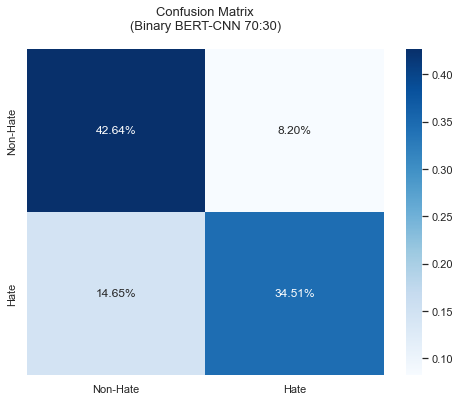

Epoch: 02

	Train Loss: 0.936
	Test Loss: 0.392

	Accuracy: 0.8223 | F1-Score: 0.8293
	Precision: 0.7855 | Recall: 0.8781

	Classification Report:

              precision    recall  f1-score   support

           0     0.8671    0.7682    0.8147       781
           1     0.7855    0.8781    0.8293       755

    accuracy                         0.8223      1536
   macro avg     0.8263    0.8232    0.8220      1536
weighted avg     0.8270    0.8223    0.8218      1536


[[600 181]
 [ 92 663]]


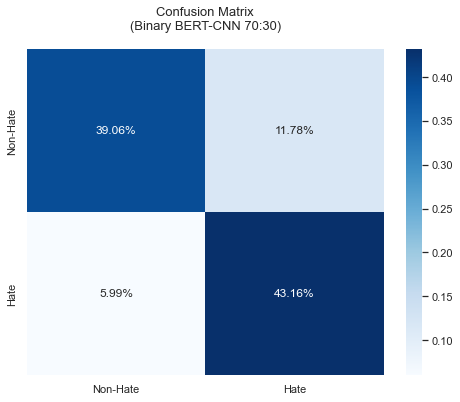

Epoch: 03

	Train Loss: 0.584
	Test Loss: 0.345

	Accuracy: 0.8542 | F1-Score: 0.8573
	Precision: 0.8258 | Recall: 0.8914

	Classification Report:

              precision    recall  f1-score   support

           0     0.8863    0.8182    0.8509       781
           1     0.8258    0.8914    0.8573       755

    accuracy                         0.8542      1536
   macro avg     0.8560    0.8548    0.8541      1536
weighted avg     0.8565    0.8542    0.8540      1536


[[639 142]
 [ 82 673]]


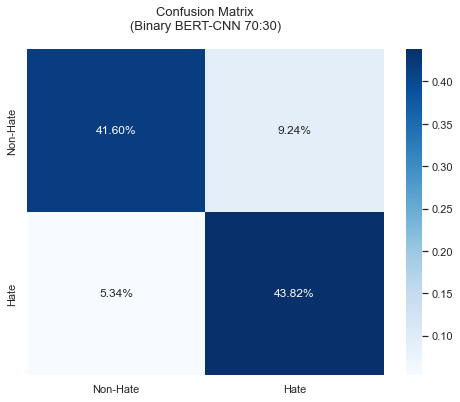

Epoch: 04

	Train Loss: 0.387
	Test Loss: 0.333

	Accuracy: 0.8704 | F1-Score: 0.8743
	Precision: 0.8357 | Recall: 0.9166

	Classification Report:

              precision    recall  f1-score   support

           0     0.9110    0.8259    0.8664       781
           1     0.8357    0.9166    0.8743       755

    accuracy                         0.8704      1536
   macro avg     0.8734    0.8712    0.8703      1536
weighted avg     0.8740    0.8704    0.8703      1536


[[645 136]
 [ 63 692]]


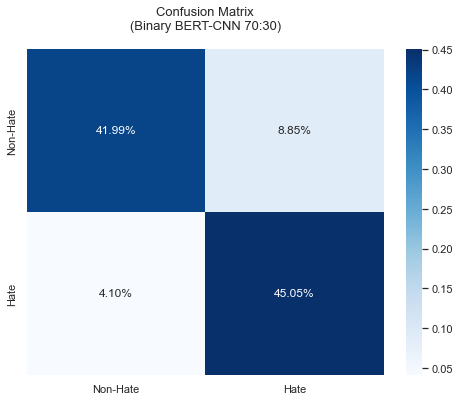

Epoch: 05

	Train Loss: 0.265
	Test Loss: 0.357

	Accuracy: 0.8639 | F1-Score: 0.8693
	Precision: 0.8235 | Recall: 0.9205

	Classification Report:

              precision    recall  f1-score   support

           0     0.9133    0.8092    0.8581       781
           1     0.8235    0.9205    0.8693       755

    accuracy                         0.8639      1536
   macro avg     0.8684    0.8649    0.8637      1536
weighted avg     0.8691    0.8639    0.8636      1536


[[632 149]
 [ 60 695]]


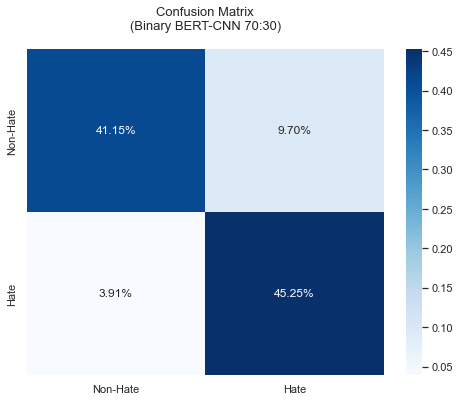

Epoch: 06

	Train Loss: 0.177
	Test Loss: 0.381

	Accuracy: 0.8861 | F1-Score: 0.8886
	Precision: 0.8554 | Recall: 0.9245

	Classification Report:

              precision    recall  f1-score   support

           0     0.9208    0.8489    0.8834       781
           1     0.8554    0.9245    0.8886       755

    accuracy                         0.8861      1536
   macro avg     0.8881    0.8867    0.8860      1536
weighted avg     0.8887    0.8861    0.8860      1536


[[663 118]
 [ 57 698]]


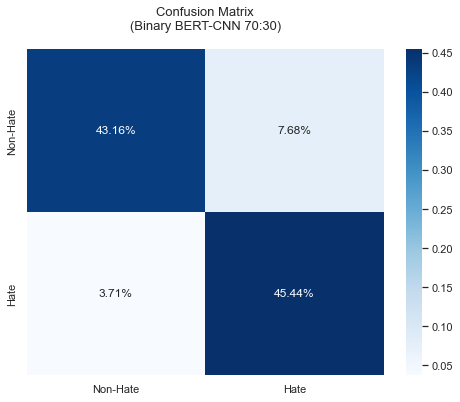

Epoch: 07

	Train Loss: 0.108
	Test Loss: 0.406

	Accuracy: 0.8815 | F1-Score: 0.8839
	Precision: 0.8524 | Recall: 0.9179

	Classification Report:

              precision    recall  f1-score   support

           0     0.9142    0.8464    0.8790       781
           1     0.8524    0.9179    0.8839       755

    accuracy                         0.8815      1536
   macro avg     0.8833    0.8821    0.8815      1536
weighted avg     0.8838    0.8815    0.8814      1536


[[661 120]
 [ 62 693]]


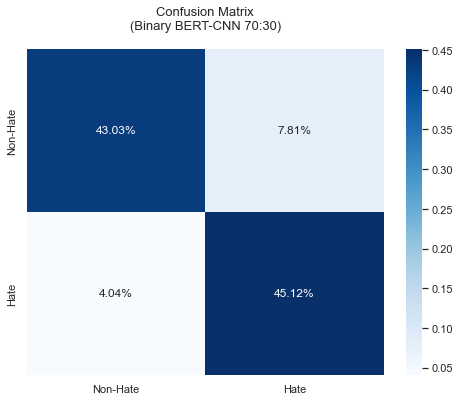

Epoch: 08

	Train Loss: 0.091
	Test Loss: 0.420

	Accuracy: 0.8763 | F1-Score: 0.8794
	Precision: 0.8441 | Recall: 0.9179

	Classification Report:

              precision    recall  f1-score   support

           0     0.9133    0.8361    0.8730       781
           1     0.8441    0.9179    0.8794       755

    accuracy                         0.8763      1536
   macro avg     0.8787    0.8770    0.8762      1536
weighted avg     0.8793    0.8763    0.8762      1536


[[653 128]
 [ 62 693]]


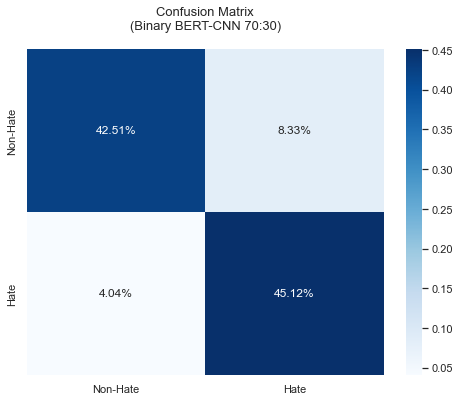

Epoch: 09

	Train Loss: 0.086
	Test Loss: 0.462

	Accuracy: 0.8822 | F1-Score: 0.8855
	Precision: 0.8475 | Recall: 0.9272

	Classification Report:

              precision    recall  f1-score   support

           0     0.9225    0.8387    0.8786       781
           1     0.8475    0.9272    0.8855       755

    accuracy                         0.8822      1536
   macro avg     0.8850    0.8829    0.8821      1536
weighted avg     0.8856    0.8822    0.8820      1536


[[655 126]
 [ 55 700]]


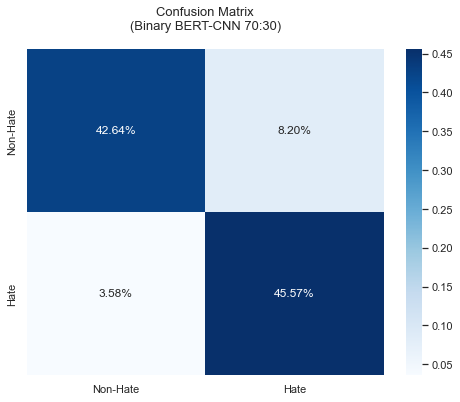

Epoch: 10

	Train Loss: 0.067
	Test Loss: 0.506

	Accuracy: 0.8783 | F1-Score: 0.8813
	Precision: 0.8463 | Recall: 0.9192

	Classification Report:

              precision    recall  f1-score   support

           0     0.9148    0.8387    0.8751       781
           1     0.8463    0.9192    0.8813       755

    accuracy                         0.8783      1536
   macro avg     0.8806    0.8789    0.8782      1536
weighted avg     0.8812    0.8783    0.8781      1536


[[655 126]
 [ 61 694]]


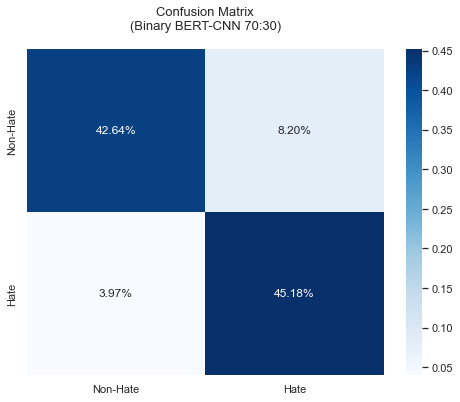

Best Model saved at epoch 4 with Test Loss: 0.333


In [30]:
from sklearn.metrics import classification_report
best_test_loss = float('inf')
best_epoch = 0

N_EPOCHS = 10
predicted_labels_per_epoch = []
true_labels_per_epoch = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator)
    test_loss, accuracy, f1, precision, recall, predicted_labels, true_labels = evaluate(model, test_iterator)
    
    # Save the predicted_labels and true_labels for the current epoch
    predicted_labels_per_epoch.append(predicted_labels)
    true_labels_per_epoch.append(true_labels)

    # Print other metrics (e.g., accuracy, loss) for the current epoch
    print(f'Epoch: {epoch + 1:02}\n')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTest Loss: {test_loss:.3f}\n')
    print(f'\tAccuracy: {accuracy:.4f} | F1-Score: {f1:.4f}')
    print(f'\tPrecision: {precision:.4f} | Recall: {recall:.4f}\n')
    print(f'\tClassification Report:\n')
    report = classification_report(true_labels, predicted_labels, target_names=["0", "1"], digits=4)
    print(f'{report}\n')
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np  # Import numpy for matrix normalization

    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(true_labels, predicted_labels)
    print(cf_matrix)

    # Plot the confusion matrix using seaborn
    sns.set(rc={"figure.figsize": (8, 6)})
    ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'], fmt='.2%', cmap='Blues')

    plt.title('Confusion Matrix\n(Binary BERT-CNN 70:30)\n', fontsize=13)
    plt.show()
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_epoch = epoch

        # Save CNN model
        torch.save(model.state_dict(), 'THESIS-70-30-WO-Hashtags-Cased-CNN.pt')

        # Save BERT model
        torch.save(bert_model.state_dict(), 'THESIS-70-30-WO-Hashtags-Cased-BERT.pt')

# Print information about the best epoch
print(f"Best Model saved at epoch {best_epoch + 1} with Test Loss: {best_test_loss:.3f}")
